In [1]:
cd mrp

/home/choiwh/hs/mrp


In [2]:
import models
import text
import mrdataset

import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from collections import Counter

from tqdm import tqdm

In [3]:
text_converter = text.KoreanText(symbol_from_data=False)

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVCIES"]="0"

In [26]:
device = 'cuda'

model = models.MovieRatingModel(symbol_size=len(text_converter.phonemes_list)).to(device)
model.load_state_dict(torch.load('./0epoch'))
model.eval()

MovieRatingModel(
  (embedding): Embedding(163, 128)
  (blstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc_1): Linear(in_features=256, out_features=128, bias=True)
  (attn): Linear(in_features=128, out_features=128, bias=True)
  (attn_w): Linear(in_features=128, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [6]:
text_converter.text_to_idx("안녕하세요")

[85, 93, 117, 76, 99, 134, 92, 93, 83, 98, 85, 105]

In [7]:
input_text = text_converter.text_to_idx("언제적영화냐 그만하자ㅋㅋ모야이건")

In [8]:
input_text = torch.nn.utils.rnn.pad_sequence(torch.LongTensor([input_text]), batch_first=True).to(device)

print(model(input_text, torch.LongTensor([len(input_text)]).to(device)))

tensor([[-0.1168, -1.7494, -1.5775, -1.5531, -0.9207, -0.9455, -0.6446, -0.3199,
         -0.2022,  1.3836]], device='cuda:0', grad_fn=<AddmmBackward>)


In [9]:
print(model(input_text, torch.LongTensor([len(input_text)])).argmax(1))

tensor([9], device='cuda:0')


---

In [9]:
valid_dataset = mrdataset.MovieRateDataset(text_path='../valid_data', label_path='../valid_label')
valid_dataloader = DataLoader(valid_dataset, batch_size=1024, collate_fn=valid_dataset.collate_batch)

In [10]:
model.eval()
total_acc, total_count = 0, 0

outputs = []

c = 0
with torch.no_grad():
    for i, (label, text, input_len) in enumerate(valid_dataloader):
        label = label.to(device)
        text = text.to(device)
        input_len = input_len.to(device)

        predited_label = model(text, input_len)

        outputs.append(predited_label.argmax(1))
        total_acc += (predited_label.argmax(1) == label).sum().item()

        total_count += label.size(0)
        
    outputs = torch.cat(outputs)

(array([7.130e+02, 4.000e+00, 2.000e+00, 1.000e+00, 6.000e+00, 1.290e+02,
        1.670e+02, 1.460e+02, 2.000e+01, 8.812e+03]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

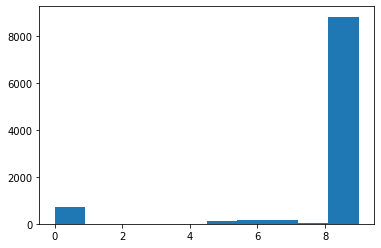

In [11]:
total_acc/total_count

plt.hist(outputs, bins=10)

In [12]:
tmp = Counter(outputs.numpy())

In [13]:
sum(tmp.values())

10000

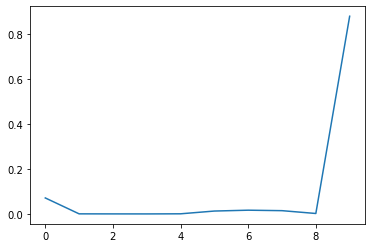

In [14]:
tmp = Counter(outputs.numpy())

plt.plot([tmp[x]/sum(tmp.values()) for x in range(10)])
plt.show()

---

# test

In [10]:
test_dataset = mrdataset.MovieRateDataset(text_path='../test_data', label_path=None, sort_text=False)
test_dataloader = DataLoader(test_dataset, batch_size=1024, collate_fn=test_dataset.collate_batch, shuffle=False)

In [27]:
model.eval()

outputs = []
with torch.no_grad():
    for i, (_, text, input_len) in tqdm(enumerate(test_dataloader)):
        text = text.to(device)
        input_len = input_len.to(input_len)

        predited_label = model(text, input_len)

        outputs.append(predited_label.argmax(1))
        if i == 0 :
            print(predited_label.argmax(1))

outputs = torch.cat(outputs)

2it [00:00,  8.60it/s]

tensor([9, 9, 9,  ..., 9, 9, 9], device='cuda:0')


391it [00:38, 10.14it/s]


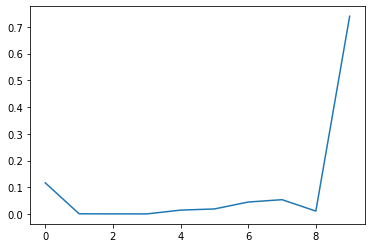

Counter({9: 295735, 0: 46585, 7: 21423, 6: 17900, 5: 7551, 4: 5810, 8: 4364, 1: 318, 2: 178, 3: 136})


In [28]:
tmp = Counter(outputs.cpu().numpy())

plt.plot([tmp[x]/sum(tmp.values()) for x in range(10)])
plt.show()

print(tmp)

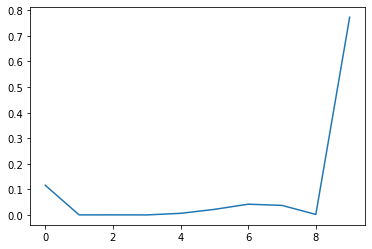

In [20]:
tmp = Counter(outputs.cpu().numpy())

plt.plot([tmp[x]/sum(tmp.values()) for x in range(10)])
plt.show()

In [21]:
tmp

Counter({9: 309152,
         0: 46407,
         6: 16878,
         4: 2581,
         7: 14956,
         5: 8755,
         8: 852,
         3: 99,
         2: 187,
         1: 133})

In [19]:
outputs.cpu().numpy()

array([9, 9, 9, ..., 9, 9, 0])

In [29]:
import csv

with open('bilstm.csv', 'w') as f:
    wr = csv.writer(f)
    wr.writerow(['ID','Prediction'])
    for i, x in enumerate(outputs.cpu().numpy()):
        wr.writerow([i,x+1])

In [25]:
test_dataset[13]

('경찰청장 개OO끼', 1)